<a href="https://colab.research.google.com/github/Jayku88/DeepLearningWorkshop_MGUniversity/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step by step Implementation of Vision Transformers in PyTorch

In this notebook, I systematically implemented the stages of the Vision Transformers (ViT) model, combining them to construct the entire ViT architecture. The figure above, sourced from the original ViT paper titled "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (ICLR 2021), illustrates crucial components like image patches, positional embeddings, learnable class embeddings, linear projection, multi-head attention, and MLP head.
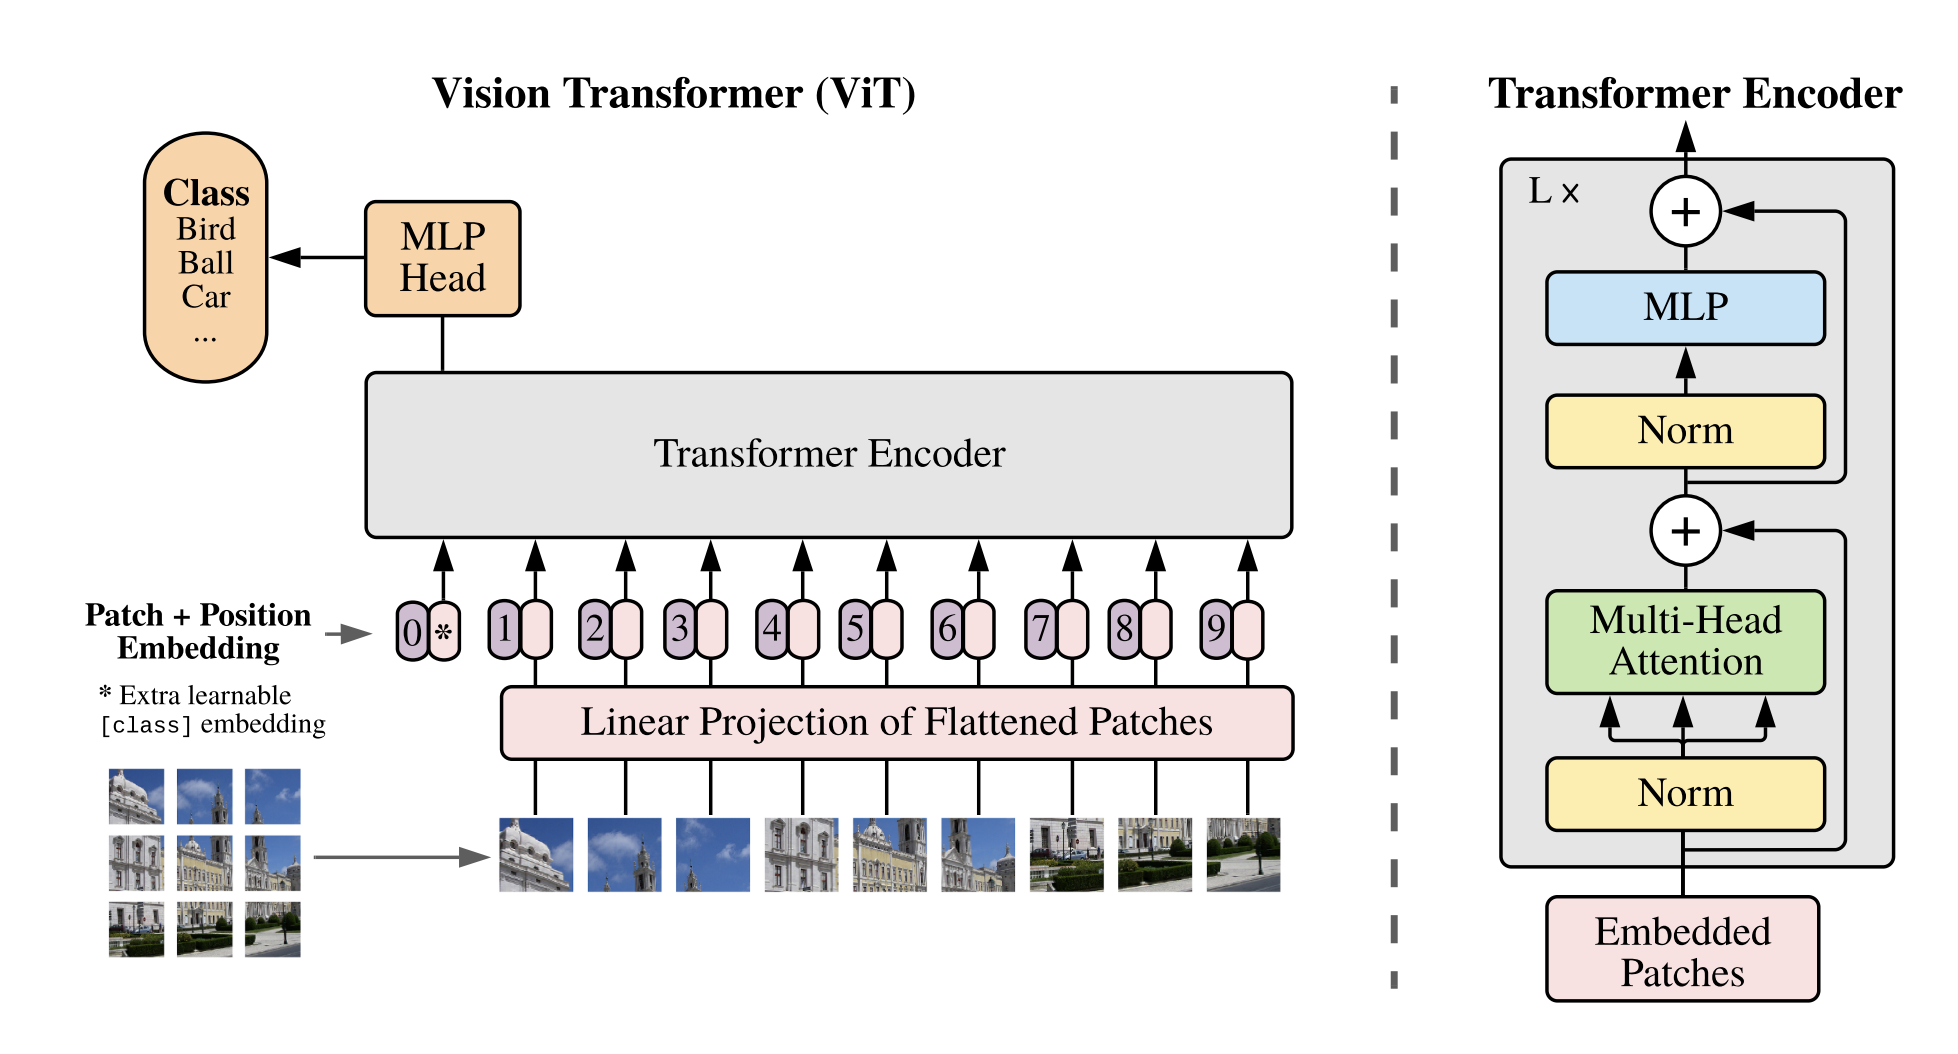
After reviewing this notebook, you will gain a clear understanding of each stage and be able to answer the following questions:

- Overview of the ViT architecture
- Explanation of image patches, class tokens, positional embeddings, Self-Attention, Multi-Head Attention, Linear Projection
- Process of creating image patches
- Initialization of class tokens and positional embeddings and their combination with image patches
- Mathematical details of the Self-Attention mechanism
- Construction of the Multi-Head Attention model from the Self-Attention layer/function

The entire implementation is carried out using the Torch framework, and the Pillow library is utilized for loading and resizing images to the desired dimensions.

# 🔧 Essential Imports for PyTorch-Based Image Processing and Deep Learning

In [1]:
# Imports
import math                           # Standard Python math library for mathematical operations
import torch                          # PyTorch library for tensor operations and deep learning
from PIL import Image                 # Pillow library for image loading and processing
from torch import nn                  # Neural network module (e.g., layers like nn.Conv2d, nn.ReLU)
from torch.nn import functional as F  # Functional interface for operations like relu, softmax, etc.
from torchvision import transforms as T  # Image transforms (e.g., resize, normalize) from torchvision

# 📦 Library Version Check for Environment Verification

In [2]:
import torch
import torchvision
import PIL
import math

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Pillow (PIL) version:", PIL.__version__)
print("Math module: Built-in, version info not applicable")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Pillow (PIL) version: 11.2.1
Math module: Built-in, version info not applicable


The authors conducted experiments using three different architectures by modifying the parameters, as indicated in the table below. In this notebook, ViT-Base will be implemented, and the parameters initialized in the next cell are configured accordingly for that model.
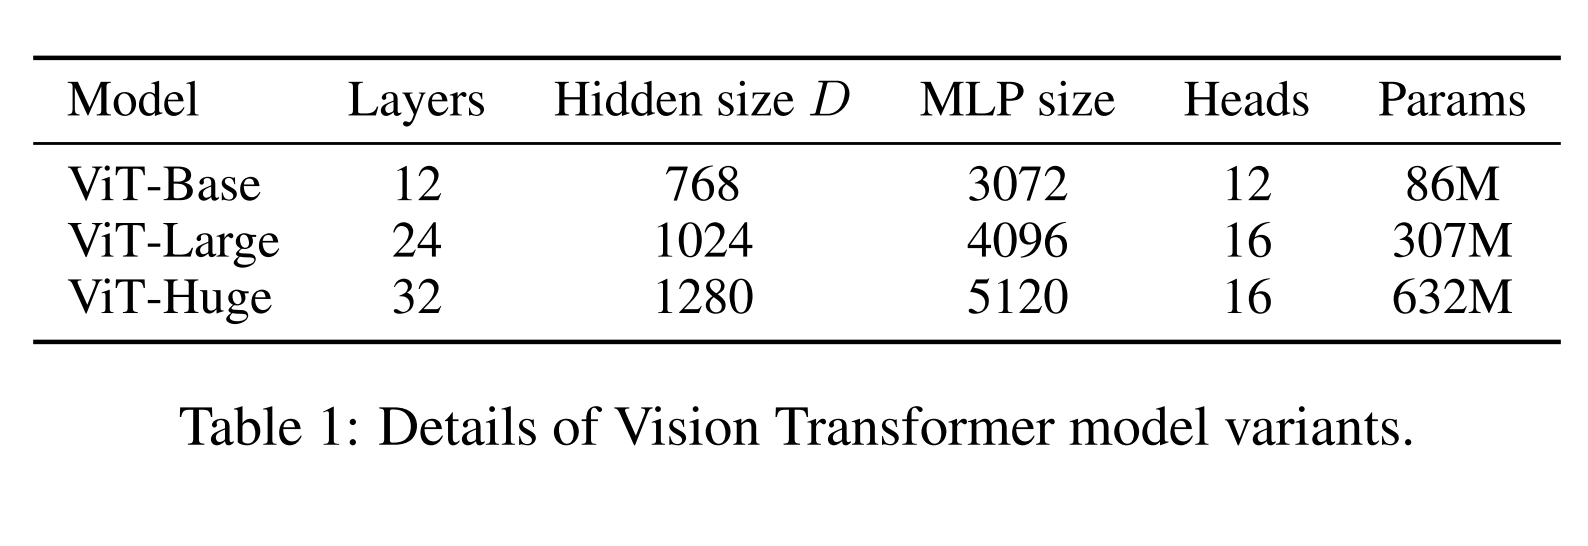

# 📐 Define Hyperparameters for Vision Transformer Architecture

In [3]:
# Introduce some parameters
desired_image_size = 224                  # The desired size is 224 as mentioned in the paper
B = batch_size = 2                        # Batch Size
P = patch_size = 16                       # patch size
C = num_channels = 3                      # number of channels (RGB)
D = embedding_dim = 768                   # dimension of the patch embeddings
num_layers = 12                           # Number of layers in ViT model
num_heads = 12                            # Number of heads in ViT model
hidden_dim = 3072                         # hidden layer dimension in MLP

https://github.com/Jayku88/DeepLearningWorkshop_MGUniversity/blob/main/photo.jpg

**Download image from above link and upload photo.jpg to Files Section in Colab (Left pane)**

#🖼️ Load and Preprocess Input Image for ViT

In [4]:
# Load an image from the file 'photo.jpg'
image = Image.open('photo.jpg')

# Resize the image to (224, 224) as required by ViT input
image = image.resize((desired_image_size, desired_image_size))

# Print the image size and mode to verify correctness
print(f'Image size:{image.size} and mode:{image.mode}. Image should be an RGB image with size of (224,224).')

# Ensure the image is exactly 224x224 pixels
assert image.size == (224, 224)

# Ensure the image is in RGB mode (3 channels)
assert image.mode == 'RGB'

Image size:(224, 224) and mode:RGB. Image should be an RGB image with size of (224,224).


# 🧱 Convert Image to Tensor and Create a Batched Input for ViT

In [5]:
# Convert the Pillow image to a PyTorch tensor with shape (C, H, W)
image_tensor = T.PILToTensor()(image)  # Converts PIL image pixels to a tensor (uint8)

# Create a batch by replicating the tensor B times (batch size = 2 here)
image_batch = torch.stack([image_tensor for _ in range(B)])  # Shape becomes (B, C, H, W)

# Print the shape of the batch tensor to verify its dimensions
print(f'Shape of the tensor, (B, C, W, H): {list(image_batch.shape)}')

# Confirm that the batch tensor has the expected shape [2, 3, 224, 224]
assert list(image_batch.shape) == [2, 3, 224, 224]

Shape of the tensor, (B, C, W, H): [2, 3, 224, 224]


#🧩 Calculate Number of Patches and Patch Dimension for Vision Transformer

Figure below shows the mathematical calculation of the image patches only for one image. In the implementation, batch supported version is implemented.
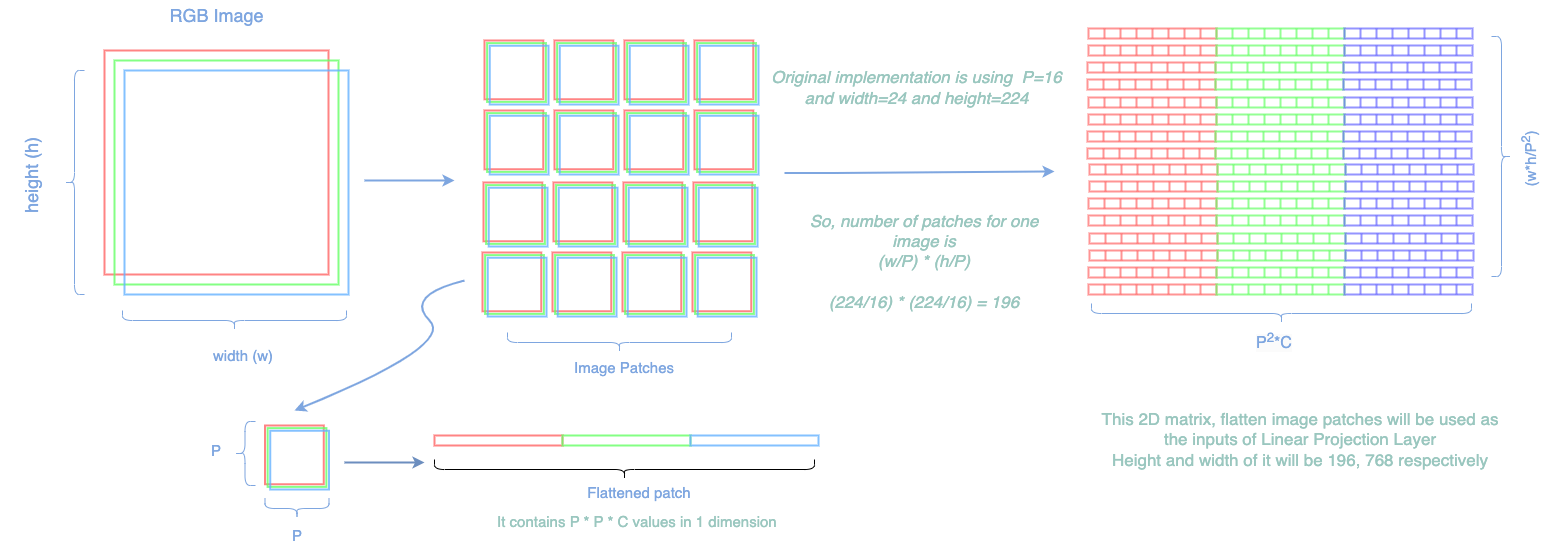
Patches are generated from the given image with a size of 16x16 without overlapping. In this case, the number of patches created is calculated as (224/16) * (224/16) = 196. As the transformer architecture doesn't accept 3D/4D inputs, each patch is flattened and stacked together. This results in 2D patches with a size of (196, (patch_size * patch_size * number of channels)).

For our configuration, this translates to (196, (16 * 16 * 3)) = (196, 768)

In [6]:
# Calculate the total number of patches by dividing the image area by the patch area
number_of_patches = int((desired_image_size * desired_image_size) / (P * P))

# Check that the number of patches is 196 (i.e., (224/16)^2)
assert number_of_patches == 196

# Calculate the dimension of each patch by multiplying patch height, width, and channels
patch_dim = int(P * P * C)

# Check that the patch dimension is 768 (16*16*3)
assert patch_dim == 768

#🔄 Patch Extraction and Flattening for Batched Input Tensors in PyTorch

In [7]:
# Extract patches from the batched image tensor and flatten them for ViT input
# Uses PyTorch unfold to split the image into non-overlapping patches
# Credit: https://discuss.pytorch.org/t/how-to-extract-patches-from-an-image/79923/4

# Unfold the image batch tensor:
# - unfold channel dimension to keep all 3 channels intact (size=C, step=C)
# - unfold height dimension into patches of size P with stride P
# - unfold width dimension similarly into patches of size P with stride P
unfolded_batch = image_batch.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P)

# Reshape the tensor to (B, number_of_patches, patch_dim):
# - contiguous() to ensure memory layout is continuous before reshaping
# - view() flattens each patch into a vector of size C * P * P
# - convert tensor to float type for neural network input
flattened_patches = unfolded_batch.contiguous().view(B, -1, C * P * P).float()

# Print the shape of patches for the first image in the batch (should be [196, 768])
print(f"Shape of one flattened Patch: {flattened_patches[0].shape}")

# Verify that the flattened patch tensor has shape: (batch_size, number_of_patches, patch_dim)
assert list(flattened_patches.shape) == [B, number_of_patches, patch_dim]


Shape of one flattened Patch: torch.Size([196, 768])


# 🟰 Linear Projection of Flattened Patches into Embedding Space

After obtaining flattened patches, patch embeddings are generated by multiplying the patches with learnable parameters. This multiplication transforms the dimension of the patches to the desired dimension, denoted as D. Following this, similar to the approach in the BERT paper, learnable class tokens are prepended to the patch embeddings. Lastly, learnable positional embeddings are added, and the output of this process serves as the input to the Transformer Encoder model.
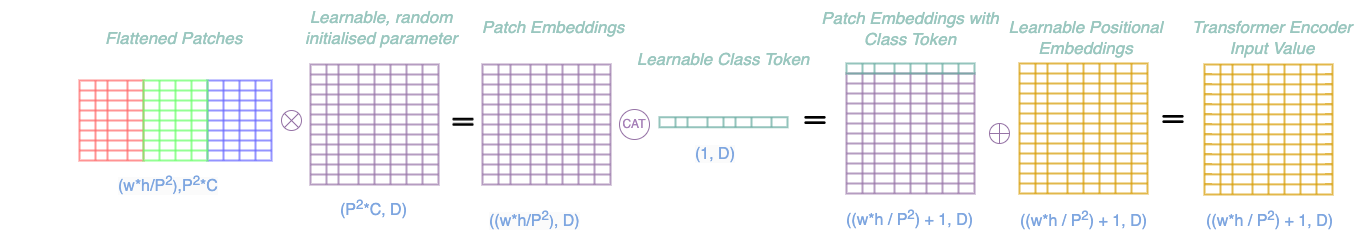

The Linear Projection step involves transforming flattened patch embeddings into a higher-dimensional space using a learnable weight matrix and bias vector. This process enhances the model's capacity to capture complex patterns and features in the image. The output of this step, along with learnable class tokens and positional embeddings, serves as the input to the Transformer Encoder model.

In [8]:
# Linear Projection process: create learnable weights to project flattened patches into embedding space

# Initialize patch projection weights of shape (patch_dim, embedding_dim) with normal distribution (mean=0, std=0.02)
patch_weights = nn.Parameter(torch.empty(P * P * C, D).normal_(std=0.02))

# Multiply flattened patches (B, number_of_patches, patch_dim) by patch_weights (patch_dim, embedding_dim)
# to get patch embeddings of shape (B, number_of_patches, D)
patch_embeddings = torch.matmul(flattened_patches, patch_weights)

# Print the shape of the patch embeddings tensor
print(f'Patch Embeddings Shape after multiplying flattened patches with learnable parameter: {list(patch_embeddings.shape)}')

# Assert the resulting shape matches expected dimensions
assert patch_embeddings.shape == (B, number_of_patches, D)

Patch Embeddings Shape after multiplying flattened patches with learnable parameter: [2, 196, 768]


#🌟 Initialize and Append Class Token to Patch Embeddings

The class token serves as a learnable parameter that provides a global representation for the entire image. It captures global information and is combined with patch embeddings before being input to the Transformer Encoder. The class token aids in developing a semantic understanding of the image, complementing local features and providing a holistic context.

In [9]:
# Initialize a learnable class token with shape (1, 1, D), initialized from a normal distribution
class_token = nn.Parameter(torch.empty(1, 1, D).normal_(std=0.02))

# Expand the class token across the batch dimension to shape (B, 1, D)
batch_class_token = class_token.expand(B, -1, -1)

# Concatenate the class token at the beginning of the patch embeddings along the sequence dimension
patch_embeddings_with_class_token = torch.cat([batch_class_token, patch_embeddings], dim=1)

# Print the shape of the patch embeddings tensor after adding the class token
print(f'Patch Embeddings + Class Token should have a shape of (B, number_of_patches + 1, D): {list(patch_embeddings_with_class_token.shape)}')

# Verify the shape is as expected: batch size, number_of_patches + 1 (class token), embedding dimension
assert patch_embeddings_with_class_token.shape == (B, number_of_patches + 1, D)

Patch Embeddings + Class Token should have a shape of (B, number_of_patches + 1, D): [2, 197, 768]


#🧭 Add Positional Embeddings to Patch + Class Token Embeddings

Position embeddings are learnable vectors that encode the spatial positions of patches in the input sequence. Added to patch embeddings, they provide crucial spatial information, allowing the model to understand the sequential order and relationships between patches. Position embeddings enable the Transformer to attend to spatial positions during self-attention, enhancing the model's ability to capture contextual information in visual tasks.

In [10]:
# Addition of the Positional Embeddings to Patch Embeddings with Class Tokens

# Initialize learnable positional embeddings of shape (B, number_of_patches + 1, D)
# This provides each token (including class token) with a unique position-aware representation
positional_embedding = nn.Parameter(torch.empty(B, number_of_patches + 1, D).normal_(std=0.02))

# Add positional embeddings to the combined class + patch token embeddings
# This step injects information about the position of each token in the sequence
embeddings = patch_embeddings_with_class_token + positional_embedding

# Print the final embedding shape ready for input to the Transformer
print(f'Embeddings shape which are ready to be fed to Transformer model: {embeddings.shape}')

# Verify that the final embeddings tensor has the correct shape
# (B, number_of_patches + 1, D): includes class token + all patch embeddings
assert embeddings.shape == (B, number_of_patches + 1, D)

Embeddings shape which are ready to be fed to Transformer model: torch.Size([2, 197, 768])


#🧠 Self-Attention: Functional Implementation of QKV Projections and Attention Computation

Self-Attention mechanism allows the model to weigh the importance of different elements in a sequence when processing each element.
It contains three vectors called Key, Query, and Value Vectors.
Each input element (token or patch) is associated with three vectors:
- Query (Q): Represents the element's information.
- Key (K): Helps the model understand the relationships between elements.
- Value (V): Holds the actual information associated with the element.
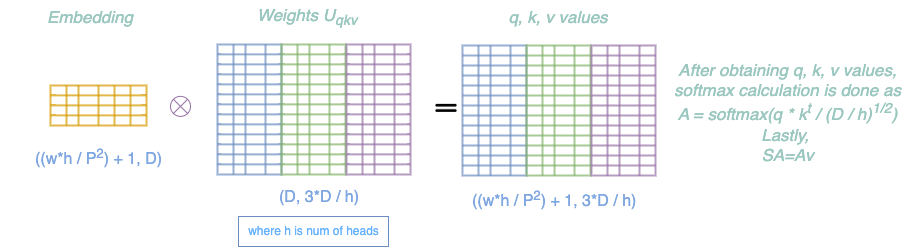
Scores are computed by dot products of Q and K, then scaled and softmaxed to obtain attention weights. These weights determine the importance of each element. The weighted sum of Values produces a context vector.

Self-Attention enables the model to understand spatial dependencies and features in image patches, considering both local and global context.

In [11]:
# Functional implementation which can't be attached to the Torch Module (for illustration/debugging purposes)

# Compute the dimension for Query, Key, and Value vectors per head
qkv_dim = int(D / num_heads)

# The learnable weight matrix W is initialized to project embeddings into Q, K, and V spaces
# Shape: (1, embedding_dim, 3 * qkv_dim) for generating Q, K, and V from input embeddings
W = nn.Parameter(torch.empty(1, D, int(3 * qkv_dim)).normal_(std=0.02))

# Linearly project embeddings to obtain concatenated Q, K, V vectors
# Resulting shape: (B, number_of_tokens, 3 * qkv_dim)
qkv = torch.matmul(embeddings, W)

# Slice Q, K, V from the concatenated result
q = qkv[:, :, :qkv_dim]                        # Query: Slice from start up to qkv_dim
k = qkv[:, :, qkv_dim:qkv_dim*2]               # Key: Slice from qkv_dim to qkv_dim*2
v = qkv[:, :, qkv_dim*2:]                      # Value: Slice from qkv_dim*2 to end

# Compute scaled dot-product attention scores
# - Multiply Q with the transpose of K (last two dims)
# - Scale by square root of qkv_dim for numerical stability
# - Apply softmax across token dimension to get attention weights
attention_weights = F.softmax(
    torch.matmul(q, torch.transpose(k, -2, -1)) / math.sqrt(qkv_dim),
    dim=1
)

# Use attention weights to compute the weighted sum of values
attention_values = torch.matmul(attention_weights, v)

# Output shape should be (B, number_of_tokens, qkv_dim)
print(f'Shape of the Attention values: {attention_values.shape}')
assert attention_values.shape == (B, number_of_patches + 1, qkv_dim)

Shape of the Attention values: torch.Size([2, 197, 64])


# 🧠 Encapsulated Self-Attention Layer as a PyTorch Module

As Self-Attention is used several times in Multi-Head Attention, it will be wise to convert it to a Torch Module as below.

In [12]:
# Self Attention Module
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim, qkv_dim):
        super(SelfAttention, self).__init__()

        # Store the embedding and qkv dimensions
        self.embedding_dim = embedding_dim   # Total input embedding dimension (D)
        self.qkv_dim = qkv_dim               # Dimension for Query, Key, and Value vectors per token

        # Initialize a learnable weight matrix to project input embeddings into Q, K, and V
        # Shape: (1, D, 3*qkv_dim) — one for Q, one for K, one for V
        self.W = nn.Parameter(
            torch.empty(1, embedding_dim, 3 * qkv_dim).normal_(std=0.02)
        )

    def forward(self, embeddings):
        # Project the input embeddings into a combined QKV tensor
        # Shape after matmul: (B, N, 3*qkv_dim)
        qkv = torch.matmul(embeddings, self.W)

        # Slice Q, K, V from the combined QKV tensor
        q = qkv[:, :, :self.qkv_dim]                     # Query
        k = qkv[:, :, self.qkv_dim:self.qkv_dim * 2]     # Key
        v = qkv[:, :, self.qkv_dim * 2:]                 # Value

        # Compute attention scores using scaled dot-product of Q and K^T
        # Then apply softmax to get attention weights
        # Shape: (B, N, N), where N = number of tokens
        attention_weights = F.softmax(
            torch.matmul(q, torch.transpose(k, -2, -1)) / math.sqrt(self.qkv_dim),
            dim=1
        )

        # Compute the final attention output by weighting the values (V)
        # Shape: (B, N, qkv_dim)
        return torch.matmul(attention_weights, v)

#⚙️ Instantiate and Apply Self-Attention Module

In [13]:
# Initialize the SelfAttention module
# Note: qkv_dim here is set to 3 * qkv_dim because the class expects the dimension of Q, K, V combined
self_attention = SelfAttention(embedding_dim=D, qkv_dim=int(3 * qkv_dim))

# Pass the embeddings through the self-attention module to get attention values
attention_values = self_attention(embeddings)

# Print the shape of the resulting attention values tensor
print(f'Shape of the Attention values: {attention_values.shape}')

# Assert that the shape is as expected:
# batch size, number_of_patches + 1 tokens (including class token), and 3*qkv_dim (combined Q,K,V dimension)
assert attention_values.shape == (B, number_of_patches + 1, int(3 * qkv_dim))

Shape of the Attention values: torch.Size([2, 197, 192])


#🧩 Multi-Head Attention Module: Combining Multiple Self-Attention Heads

Multi-head attention module enhances the model's capability by allowing it to focus on various aspects of input patches simultaneously. It involves linear projections of Query (Q), Key (K), and Value (V) vectors for each attention head (as implemented above), followed by independent scaled dot-product attention computations. The outputs from different heads are concatenated, linearly transformed, and serve as the final result, enabling the model to capture diverse features and relationships in the input image patches.

In [14]:
# Multi-Head Attention Module
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads               # Number of attention heads
        self.embedding_dim = embedding_dim       # Total embedding dimension (D)

        # Calculate dimension of Q, K, V per head
        self.qkv_dim = embedding_dim // num_heads

        # Initialize a list of SelfAttention modules, one for each head
        # Each SelfAttention handles qkv_dim-sized embeddings
        self.multi_head_attention = nn.ModuleList(
            [SelfAttention(embedding_dim, self.qkv_dim) for _ in range(num_heads)]
        )

        # Learnable weight matrix to combine concatenated outputs from all heads
        # Shape: (1, num_heads * qkv_dim, embedding_dim)
        self.W = nn.Parameter(
            torch.empty(1, num_heads * self.qkv_dim, embedding_dim).normal_(std=0.02)
        )

    def forward(self, x):
        # Compute self-attention output for each head separately
        attention_scores = [attention(x) for attention in self.multi_head_attention]

        # Concatenate the outputs from all heads along the last dimension
        Z = torch.cat(attention_scores, -1)

        # Project the concatenated outputs back to embedding_dim space
        # This combines information from all heads into a single representation
        return torch.matmul(Z, self.W)

#⚙️ Initialize and Compute Multi-Head Attention Output

In [15]:
# Initialize the MultiHeadAttention module with embedding dimension and number of heads
multi_head_attention = MultiHeadAttention(D, num_heads)

# Pass the embeddings (including class token) through the multi-head attention module
multi_head_attention_score = multi_head_attention(patch_embeddings_with_class_token)

# Print the shape of the output attention scores tensor
print(f'Shape of the Multi-Head Attention: {multi_head_attention_score.shape}')

# Assert that the output shape matches the expected shape:
# batch size, number_of_patches + 1 (including class token), and embedding dimension
assert multi_head_attention_score.shape == (B, number_of_patches + 1, D)

Shape of the Multi-Head Attention: torch.Size([2, 197, 768])


#🧠 Feedforward MLP Block with GELU Activation

The MLP module enhances the model's representation by applying linear transformations, non-linear activation functions, and a final linear transformation to the multi-head attention scores.
It introduces non-linearity, enabling the model to capture complex patterns and relationships within the data.
This step further refines the representation and prepares it for subsequent layers in the architecture.

In [16]:
# Multi-Layer Perceptron (MLP) block used as the feedforward network in Transformer
class MLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(MLP, self).__init__()

        # Define a sequential model with:
        # - Linear layer projecting from embedding_dim to hidden_dim
        # - GELU activation function (smooth nonlinear activation)
        # - Linear layer projecting back from hidden_dim to embedding_dim
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        # Forward pass through the MLP layers
        return self.mlp(x)

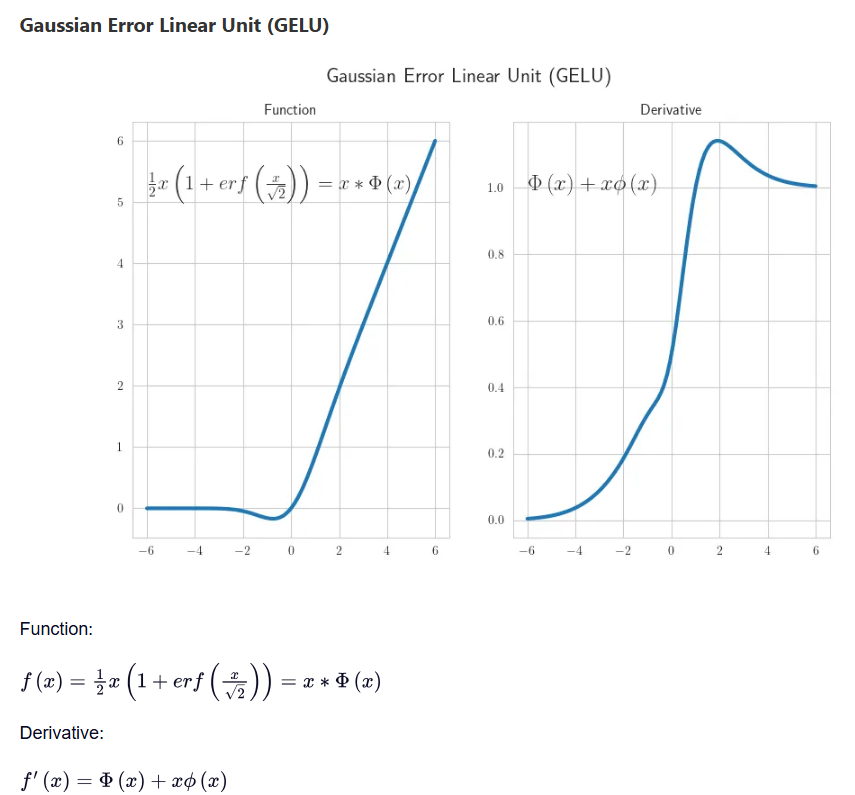

https://ml-explained.com/blog/activation-functions-explained

# ⚙️ Initialize MLP and Compute Feedforward Output

In [17]:
# Initialize the MLP module with embedding dimension and hidden layer size
mlp = MLP(D, hidden_dim)

# Pass the output from multi-head attention through the MLP feedforward network
output = mlp(multi_head_attention_score)

# Assert that the output shape matches the expected shape:
# batch size, number_of_patches + 1 tokens, and embedding dimension
assert output.shape == (B, number_of_patches + 1, D)

# Print the shape of the MLP output tensor
print(F'Shape of MLP output: {output.shape}')

Shape of MLP output: torch.Size([2, 197, 768])


#🏗️ Transformer Encoder Module Implementation

Having implemented all the essential functionalities step by step, we can now introduce the Transformer Encoder Module by combining the necessary functions.

In [18]:
# Transformer Encoder Module
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, dropout):
        super(TransformerEncoder, self).__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, num_heads)
        self.mlp = MLP(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)

    def forward(self, embeddings):
        # Applying dropout
        dropout_embeddings = self.dropout1(embeddings)
        # Layer normalization
        normalized_embeddings = self.layer_norm1(dropout_embeddings)
        # Calculation of multi-head attention
        attention_scores = self.multi_head_attention(normalized_embeddings)
        # Applying the second dropout
        dropout_attention_scores = self.dropout2(attention_scores)
        # Residual connection with second dropout output and initial input
        residuals_embeddings = embeddings + dropout_attention_scores
        # apply layer normalization
        normalized_residuals_embeddings = self.layer_norm2(residuals_embeddings)
        # aply MLP
        transformed_results = self.mlp(normalized_residuals_embeddings)
        # Applying the third dropout
        dropout_transformed_results = self.dropout3(transformed_results)
        # Residual connection with last dropout output and first residual output
        output = residuals_embeddings + dropout_transformed_results

        return output

#⚙️ Initialize and Run Transformer Encoder Layer

In [19]:
# init transformer encoder
transformer_encoder = TransformerEncoder(embedding_dim=D, num_heads=num_heads, hidden_dim=hidden_dim, dropout=0.1)

# compute transformer encoder output
output = transformer_encoder(embeddings)

print(f'Shape of the output of Transformer Encoders: {output.shape}')
assert output.shape == (B, number_of_patches + 1, D)

Shape of the output of Transformer Encoders: torch.Size([2, 197, 768])


The output of the Transformer Encoder is a sequence of feature vectors, each corresponding to a specific patch of the input image. These feature vectors capture hierarchical and contextual information learned during the self-attention mechanism within the transformer layers. The final feature sequence is then used for downstream tasks such as classification.

#🎯 MLP Head for Classification with Training and Inference Modes

The MLP Head processes the transformer encoder's output by applying global average pooling, a fully connected layer, an activation function (typically softmax), and produces the final probability distribution over classes for classification tasks.

In [20]:
class MLPHead(nn.Module):
    def __init__(self, embedding_dim, num_classes, is_train=True):
        super(MLPHead, self).__init__()
        self.num_classes = num_classes
        # this part is taken from torchvision implementation
        if is_train:
            self.head = nn.Sequential(
                                    nn.Linear(embedding_dim, 3072),  # hidden layer
                                    nn.Tanh(),
                                    nn.Linear(3072, num_classes)    # output layer
                            )
        else:
            # single linear layer
            self.head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.head(x)


#🎯 Extract Class Token and Pass Through Classification Head

In [21]:
# Classifier "token" as used by standard language architectures
class_token_output = output[:, 0]

# initialise number of classes
n_class = 10

# initialise classification head
mlp_head = MLPHead(D, n_class)

cls_output = mlp_head(class_token_output)

# size of output
print(f'Shape of the MLP Head output: {cls_output.shape}')
assert list(cls_output.shape) == [B, n_class]

Shape of the MLP Head output: torch.Size([2, 10])


#🖼️ Vision Transformer (ViT) Model Implementation

At last, implementing the Vision Transformer module which involves utilizing all the functions discussed above in accordance with the visual representations and information provided in the paper.

In [22]:
# VisionTranformer Module
class VisionTransformer(nn.Module):
    def __init__(self, patch_size=16, image_size=224, C=3,
                     num_layers=12, embedding_dim=768, num_heads=12, hidden_dim=3072,
                            dropout_prob=0.1, num_classes=10):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.C = C

        # get the number of patches of the image
        self.num_patches = int(image_size ** 2 / patch_size ** 2) # (width * height) / (patch_size**2)

        # trainable linear projection for mapping dimension of patches (weight matrix E)
        self.W = nn.Parameter(torch.empty(1, patch_size * patch_size * C, embedding_dim).normal_(std=0.02))

        # position embeddings
        self.positional_embeddings = nn.Parameter(torch.empty(1, self.num_patches + 1, embedding_dim).normal_(std=0.02))

        # learnable class tokens
        self.class_tokens = nn.Parameter(torch.rand(1, D))

        # transformer encoder
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob) for _ in range(num_layers)
        ])

        # mlp head
        self.mlp_head = MLPHead(embedding_dim, num_classes)

    def forward(self, images):
        # get patch size and channel size
        P, C = self.patch_size, self.C

        # create image patches
        patches = images.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P).contiguous().view(images.size(0), -1, C * P * P).float()

        # patch embeddings
        patch_embeddings = torch.matmul(patches , self.W)

        # class token + patch_embeddings
        batch_class_token = self.class_tokens.expand(patch_embeddings.shape[0], -1, -1)
        patch_embeddings_with_class_token = torch.cat([batch_class_token, patch_embeddings], dim=1)

        # add positional embedding
        embeddings = patch_embeddings_with_class_token + self.positional_embeddings

        # execute Transformer encoders
        transformer_encoder_output = self.transformer_encoder(embeddings)

        # Classifier "token" as used by standard language architectures
        output_class_token = transformer_encoder_output[:, 0]

        return self.mlp_head(output_class_token)

#🎯 Instantiate Vision Transformer and Perform Forward Pass on Batched Images

In [23]:
# init vision transformer model
vision_transformer = VisionTransformer(patch_size=P,
                                       image_size=desired_image_size,
                                       C=C,
                                       num_layers=num_layers,
                                       embedding_dim=embedding_dim,
                                       num_heads=num_heads,
                                       hidden_dim=hidden_dim,
                                       dropout_prob=0.1,
                                       num_classes=10)

# we can use image_batch as it is
vit_output = vision_transformer(image_batch)

assert vit_output.size(dim=1) == n_class
print(vit_output.shape)

torch.Size([2, 10])


In [24]:
vit_output

tensor([[-0.0447,  0.0962, -0.3322, -0.3071, -0.0565,  0.4706, -0.2081,  0.1965,
         -0.4739,  0.2193],
        [ 0.0061, -0.0370, -0.0533, -0.2632,  0.0719,  0.2424,  0.1143,  0.1866,
         -0.2462,  0.3850]], grad_fn=<AddmmBackward0>)

**It's absolutely normal for vit_output (the output of your Vision Transformer) to contain negative values, especially before applying an activation function like softmax or sigmoid.**

#Training and Inference (Model created by us) on CIFAR dataset

In [25]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms


In [26]:
# # Model settings
# P = 16  # patch size
# C = 3   # RGB
# desired_image_size = 224
# embedding_dim = 768
# num_heads = 12
# num_layers = 12
# hidden_dim = 3072
# n_class = 10
# batch_size = 64
# epochs = 10
# lr = 3e-4


In [27]:
# transform = transforms.Compose([
#     transforms.Resize((desired_image_size, desired_image_size)),
#     transforms.ToTensor()
# ])

# # CIFAR-10 as an example dataset
# train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=batch_size)


In [28]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# vision_transformer = VisionTransformer(
#     patch_size=P,
#     image_size=desired_image_size,
#     C=C,
#     num_layers=num_layers,
#     embedding_dim=embedding_dim,
#     num_heads=num_heads,
#     hidden_dim=hidden_dim,
#     dropout_prob=0.1,
#     num_classes=n_class
# ).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(vision_transformer.parameters(), lr=lr)


In [29]:
# for epoch in range(epochs):
#     vision_transformer.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = vision_transformer(images)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         preds = outputs.argmax(dim=1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     acc = correct / total * 100
#     print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")


In [30]:
# vision_transformer.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = vision_transformer(images)

#         preds = torch.argmax(outputs, dim=1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

# test_acc = correct / total * 100
# print(f"Test Accuracy: {test_acc:.2f}%")


***This model is very heavy to train on Google Colab T4 GPU. So we are using a small vision transformer with a tiny version of CIFAR dataset.***

#TinyVit

##🔧 1. Imports & Simple Vision Transformer

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


##🧠 2. Simple ViT-Like Classifier

In [32]:
class TinyViT(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, 64, kernel_size=4, stride=4)  # [B, 64, 8, 8]
        self.flatten = nn.Flatten(2)  # [B, 64, 64]
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 64))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=4), num_layers=2
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)  # [B, 64, 8, 8]
        x = self.flatten(x).transpose(1, 2)  # [B, 64, 64]
        cls_token = self.cls_token.expand(x.size(0), -1, -1)  # [B, 1, 64]
        x = torch.cat((cls_token, x), dim=1)  # [B, 65, 64]
        x = self.transformer(x)
        x = x[:, 0]  # take CLS token
        return self.mlp_head(x)


##🗂️ 3. Data (Tiny Subset of CIFAR-10)

In [33]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Use small subset for speed
full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
small_train = Subset(full_train, list(range(512)))  # just 512 samples
train_loader = DataLoader(small_train, batch_size=64, shuffle=True)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64)
classes = test_set.classes


## ⚙️ 4. Train Loop

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyViT(num_classes=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):  # just 2 epochs for quick run
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Loss = 2.5027, Accuracy = 7.62%
Epoch 2: Loss = 2.3309, Accuracy = 8.98%
Epoch 3: Loss = 2.3136, Accuracy = 10.94%
Epoch 4: Loss = 2.3117, Accuracy = 9.77%
Epoch 5: Loss = 2.3105, Accuracy = 9.57%
Epoch 6: Loss = 2.3123, Accuracy = 10.35%
Epoch 7: Loss = 2.3125, Accuracy = 13.48%
Epoch 8: Loss = 2.3110, Accuracy = 10.55%
Epoch 9: Loss = 2.2988, Accuracy = 12.50%
Epoch 10: Loss = 2.3031, Accuracy = 13.28%
Epoch 11: Loss = 2.3060, Accuracy = 10.35%
Epoch 12: Loss = 2.3050, Accuracy = 12.89%
Epoch 13: Loss = 2.3141, Accuracy = 12.11%
Epoch 14: Loss = 2.2985, Accuracy = 12.70%
Epoch 15: Loss = 2.2979, Accuracy = 11.91%
Epoch 16: Loss = 2.3104, Accuracy = 12.50%
Epoch 17: Loss = 2.3127, Accuracy = 11.91%
Epoch 18: Loss = 2.3106, Accuracy = 11.91%
Epoch 19: Loss = 2.3127, Accuracy = 9.18%
Epoch 20: Loss = 2.3089, Accuracy = 11.72%
Epoch 21: Loss = 2.3178, Accuracy = 11.91%
Epoch 22: Loss = 2.3118, Accuracy = 12.11%
Epoch 23: Loss = 2.3104, Accuracy = 11.13%
Epoch 24: Loss = 2.3121, 

**Please note we are only taking 512 samples from 30000 images datset.**

## 🔍 5. Inference & Visualization

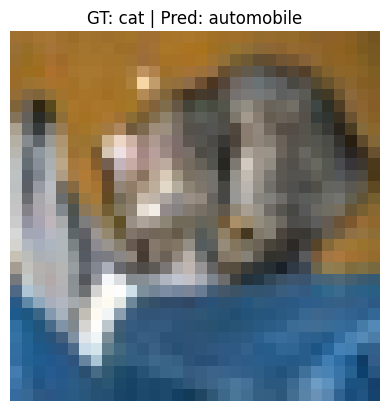

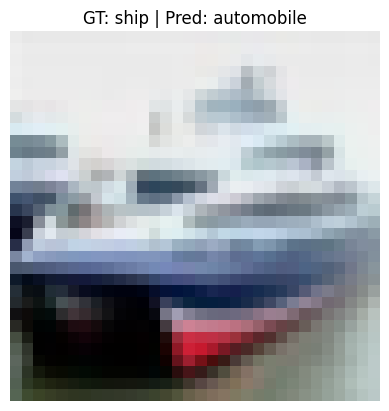

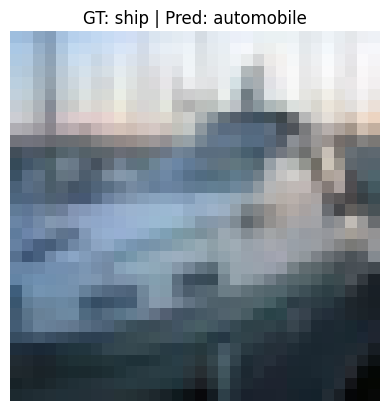

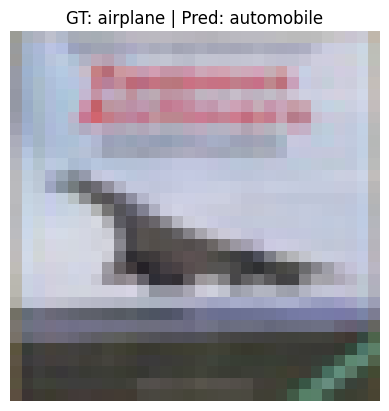

In [35]:
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# Inference on a few test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Show 4 images
for i in range(4):
    imshow(images[i], title=f"GT: {classes[labels[i]]} | Pred: {classes[preds[i]]}")
